# Comparison

We run an experiment to calculate the learning curves for the methods and measure the performance using the root mean-squared (RMS) error between the value function learned and the true value function, averaged over the five states, then averaged over 100 runs.

In [6]:
import numpy as np

def decay_alpha(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [7]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

We ran the experiment on the Random Walk (RW) environment using the "all-left" policy

In [8]:
import numpy as np
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 7
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: 
            raise ValueError('Episode has terminated');
        
        if action not in [0, 1]: 
            raise ValueError('Invalid action');
        
        self._state += np.random.choice([-1, 1])
        
        reward = 0
        
        if self._state < 1: 
            self._done = True
        
        if self._state > 5: 
            self._done = True; 
            reward = 1
        
        return self._state, reward, self._done, 0  # obs, rew, done

In [9]:
random_walk = RandomWalk()

In [10]:
def pi(state):
    return 1

MC:

In [11]:
def generate_trajectory(pi, env, max_steps=200):
    
    # list of experiences (trajectory)
    trajectory = []
    
    done = False
    steps = 0
    
    # reset the environment to interact in a new episode
    state = env.reset()

    # looping through until the done flag is set to true
    while not done:     
        steps += 1;   

        # use the policy function to pick an action
        action = pi(state) 
            
        # step the environment using that action 
        next_state, reward, done, _ = env.step(action)
        
        # append the experience to the trajectory
        experience = (state, action, reward, next_state, done)
        trajectory.append(experience)
            
        # if we hit a terminal state break and return
        if done:
            break;
                
        # truncate long trajectories
        if steps > max_steps:
            break;
            
        # update the state
        state = next_state
            
    # return the trajectory
    return np.array(trajectory, object)

In [12]:
def mc(pi, env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500, max_steps=200):
    
    nS = env.observation_space
    
    # calculate all discounts at once. 
    discounts = decay_discounts(gamma, max_steps);
    
    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
    
    # initialize the current estimate of the state-value function
    V = np.zeros(nS, dtype=float)
    
    # create a list to save copies of V for offline analysis
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # loop for every episode 
    for e in range(n_episodes):
        
        # generate a trajectory
        trajectory = generate_trajectory(pi, env, max_steps)
        
        # initialize a visits check vector
        visited = np.zeros(nS, dtype=bool)
        
        # loop through all experiences in the trajectory
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            
            # check if the state has already been visited
            if visited[state]: 
                continue
            visited[state] = True
            
            # calculate the number of steps from t to T
            n_steps = len(trajectory[t:])
            
            # calculate the return
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            
            # estimate the value function
            V[state] = V[state] + alphas[e] * (G - V[state])
        
            # keep track of the episode V
            V_track[e] = V
            
    return V.copy(), V_track

TD:

In [13]:
def td(pi, env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500):

    nS = env.observation_space
        
    # initialize the variables needed
    V = np.zeros(nS, dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # calculate the learning rate schedule for all episodes
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
    
    # loop for n_episodes
    for e in range(n_episodes):
        
        # get the initial state and then enter the interaction loop
        state, done = env.reset(), False
        
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # use the action to interact with the environment... 
            # roll out the policy one step
            next_state, reward, done, _ = env.step(action)
            
            # update V(s)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            
            # update the state variable for the next iteration
            state = next_state
            
        V_track[e] = V
        
    return V, V_track

n-step TD:

In [14]:
def generate_path(pi, env, state, n_steps):
    path = []
    done = False
    while len(path) < n_steps:
        action = pi(state) 
        next_state, reward, done, _ = env.step(action)
        experience = (state, action, reward, next_state, done)
        path.append(experience)
        if done: 
            break
        state = next_state
    return np.array(path, object)

In [15]:
def ntd(pi, env, gamma=1.0, n_steps=3, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500):

    nS = env.observation_space
    
    # calculate n_step discounts at once 
    discounts = decay_discounts(gamma, n_steps+1);
    
    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
      
    # initialize the current estimate of the state-value function
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # loop for every episode 
    for e in range(n_episodes):

        # get the initial state
        state, done = env.reset(), False

        # go collecting a series of n-state paths until we hit done
        while not done:
            # generate a path of n-steps (maximum, or less if we hit done)
            path = generate_path(pi, env, state, n_steps)
            
            # calculate the number of steps, could be ‘n_step’ but it could 
            # also be smaller if a terminal state is in the path    
            n = len(path)
        
            # initialize a visits check vector
            visited = np.zeros(nS, dtype=bool)
        
            # now loop through all experiences in the path
            for t, (path_state, _, reward, path_next_state, path_done) in enumerate(path):                
                
                # calculate the partial return
                partial_return = np.sum(discounts[:n-t] * path[t:, 2])
            
                # update the value function
                ntd_target = partial_return + discounts[n] * V[path[n-1, 3]]
                ntd_error = ntd_target - V[path_state]
                V[path_state] = V[path_state] + alphas[e] * ntd_error
                                           
                state = path_next_state
                done = path_done
                
        # keep track of the episode’s V
        V_track[e] = V
                      
    return V.copy(), V_track

TD-lambda:

In [16]:
def td_lambda(pi, env, gamma=1.0, lambda_=0.2, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500):
    nS = env.observation_space
    
    # initialize the current estimate of the state-value function V
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # initialize the eligibility trace vector
    E = np.zeros(nS, dtype=float)
    
    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);

    # loop for every episode
    for e in range(n_episodes):
        
        # set E to zero every new episode
        E.fill(0)
        
        # get the initial state
        state, done = env.reset(), False
        
        # get into the time step loop
        while not done:
            
            # sample the policy pi for the action to take in state
            action = pi(state)
            
            # interact with the environment for one step and get the experience tuple
            next_state, reward, done, _ = env.step(action)
            
            # use that experience to calculate the TD error as usual
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            
            # increment the eligibility of state by 1
            E[state] = E[state] + 1
            
            # apply the error update to all eligible states as indicated by E
            V = V + alphas[e] * td_error * E
            
            # decay E
            E = gamma * lambda_ * E
            
            state = next_state
            
        V_track[e] = V
    return V, V_track

Experiment:

In [17]:
from collections import defaultdict

def run_experiment(algorithm, nb_runs, env, pi,):
    V_init = defaultdict(lambda: 0.5)   # init V to 0.5
    V_init[0] = V_init[6] = 0.0         # but terminal states to zero !!

    V_runs = []
    for i in range(nb_runs):
        _, V_td_track = algorithm(pi,env)
        V_runs.append(V_td_track)
    V_runs = np.array(V_runs) 
    
    V_runs = V_runs[:,:,1:-1]  # remove data about terminal states (which is always zero anyway)
    error_to_true = V_runs - env.V_true[1:-1]
    squared_error = np.power(error_to_true, 2)
    mean_squared_error = np.average(squared_error, axis=-1)  # avg over states
    root_mean_squared_error = np.sqrt(mean_squared_error)
    rmse_avg_over_runs = np.average(root_mean_squared_error, axis=0)
    
    return rmse_avg_over_runs  # this is data that goes directly on the plot

In [18]:
rmse_mc = run_experiment(mc, 100, random_walk, pi)
rmse_td = run_experiment(td, 100, random_walk, pi)
rmse_ntd = run_experiment(ntd, 100, random_walk, pi)
rmse_td_lamda = run_experiment(td_lambda, 100, random_walk, pi)

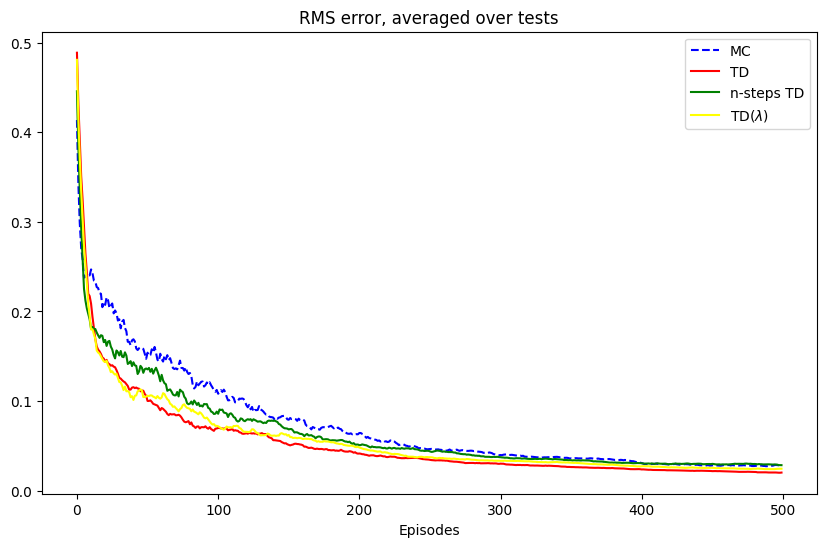

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(rmse_mc, color='blue', linestyle='--', label='MC')
plt.plot(rmse_td, color='red', linestyle='-', label='TD')
plt.plot(rmse_ntd, color='green', linestyle='-', label='n-steps TD')
plt.plot(rmse_td_lamda, color='yellow', linestyle='-', label='TD($\lambda$)')
plt.title('RMS error, averaged over tests')
plt.xlabel('Episodes')
plt.legend()

plt.show()